## Lab 1

### Part 2: Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [2]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [3]:
!nvidia-smi

Sun Nov  7 02:05:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 470.74       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   52C    P5    N/A /  N/A |    304MiB /  4040MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
results = {
    "seq2seq": {
        "bleu": 0,
        "n_params": 0,
        "train_time": 0,
        "train_loss": [],
        "val_loss": []
    },
    "transformer": {
        "bleu": 0,
        "n_params": 0,
        "train_time": 0,
        "train_loss": [],
        "val_loss": []
    }
}

In [5]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !mkdir -p data
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/datasets/Machine_translation_EN_RU/data.txt -O ./data/data.txt -nc
    path_do_data = './data/data.txt'

Dataset not found locally. Downloading from github. Loading special files as well
File ‘./data/data.txt’ already there; not retrieving.


In [6]:
if not os.path.exists('./utils.py'):
    print("utils file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_advanced/Lab1_NLP/utils.py -nc

if not os.path.exists('./my_network.py'):
    print("network file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_advanced/Lab1_NLP/my_network.py -nc

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [7]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [8]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [9]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [10]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [11]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [12]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9285
Unique tokens in target (en) vocabulary: 6685


Here are tokens from original (RU) corpus:

In [13]:
SRC.vocab.itos[::1000]

['<unk>',
 'горячей',
 'ти',
 'кондиционеры',
 'adventure',
 '240',
 'mendoza',
 'художественные',
 'долиной',
 'строгой']

And from target (EN) corpus:

In [14]:
TRG.vocab.itos[::1000]

['<unk>', 'cafe', 'gare', 'compact', 'mahal', 'smokovec', 'masjid']

And here is example from train dataset:

In [15]:
print(vars(train_data.examples[9]))

{'trg': ['private', 'bathrooms', 'come', 'with', 'a', 'shower', '.'], 'src': ['к', 'услугам', 'гостей', 'собственные', 'ванные', 'комнаты', 'с', 'душем', '.']}


Let's check the length distributions:

Length distribution in Train data


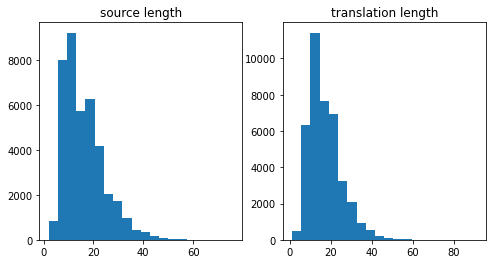

In [16]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


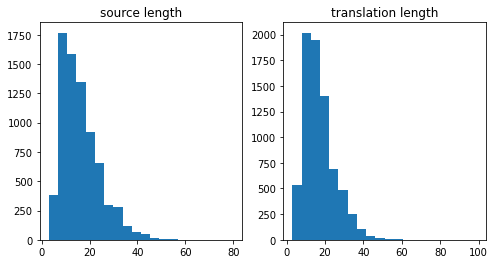

In [17]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
device

device(type='cuda')

In [20]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 256

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [21]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.legacy.data.batch.Batch of size 256]
	[.trg]:[torch.cuda.LongTensor of size 49x256 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 47x256 (GPU 0)]
torch.Size([47, 256]) torch.Size([49, 256])


In [22]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [23]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [24]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9285, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6685, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6685, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,874,141 trainable parameters


In [26]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [27]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [28]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [29]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

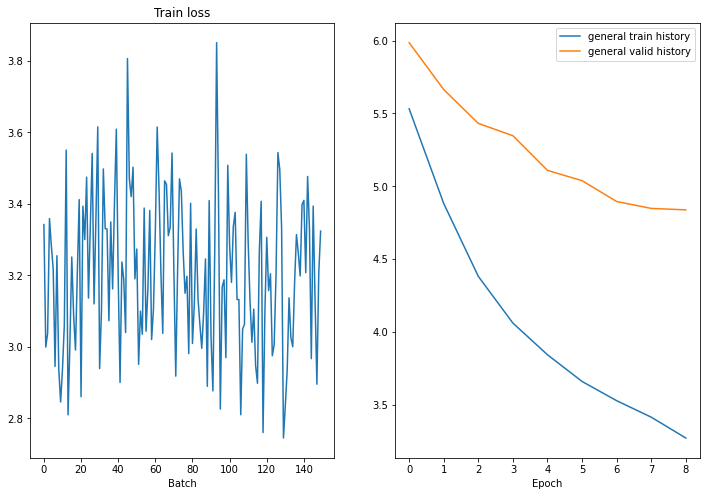

Epoch: 10 | Time: 1m 9s
	Train Loss: 3.205 | Train PPL:  24.643
	 Val. Loss: 4.762 |  Val. PPL: 116.973


In [31]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [32]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [33]:
batch = next(iter(test_iterator))

In [34]:
for idx in [10,12]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: there is a shared lounge , where guests can relax .
Generated: the room is equipped with a tv .

Original: laundry facilities are available for all guests of the hotel .
Generated: the private parking is available on site .



In [35]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [36]:
import tqdm

In [37]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

30it [00:03,  8.72it/s]


In [38]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

12.057630745164564

Baseline solution BLEU score is quite low. Try to achieve at least __24__ BLEU on the test set. 
The checkpoints are:

* __22__ - minimal score to submit the homework, 30% of points

* __27__ - good score, 70% of points

* __29__ - excellent score, 100% of points

## RNN encoder-decoder custom pipeline

In [8]:
import os
import math
import time
import csv
import shutil
import random
import itertools
from collections import Counter
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### loading & splitting

In [10]:
with open("./data/data.txt") as f:
    pairs = list(csv.reader(f, delimiter="\t", quotechar='"'))
    
print(f"Total number of pairs: {len(pairs)}")
print(f"Sample pair:\n{random.choice(pairs)}")

Total number of pairs: 50000
Sample pair:
['It offers self-catering cottages, a shared terrace with outdoor furniture and BBQ facilities.', 'К вашим услугам общая меблированная терраса, принадлежности для барбекю и коттеджи с собственной кухней.']


In [11]:
train, test = train_test_split(pairs, test_size=0.05, random_state=1)
train, val = train_test_split(train, test_size=0.15, random_state=1)

print(f"train: {len(train) / len(pairs)}")
print(f"val: {len(val) / len(pairs)}")
print(f"test: {len(test) / len(pairs)}")

train: 0.8075
val: 0.1425
test: 0.05


### preprocessing & tokenizing

In [12]:
class TextPreprocessor:
    
    def __init__(self):
        """
        """
        self.tokenizer = WordPunctTokenizer()

    def __call__(self, text, split=True):
        """
            text: text
            split: if split to tokens
            
            returns: indexes list
        """
        text = text.lower()
        if split:
            text = self.tokenizer.tokenize(text)
        
        return text
    
    def get_unique_vocab(self, corpus, min_freq=3):
        """
            get unique words from a list of sentences
        """
        corpus_words = list(map(self, corpus))
        words = Counter(list(itertools.chain(*corpus_words)))
        words = [word[0] for word in words.items() if word[1] >= 3]
        return words

In [13]:
class TextTokenizer:
    
    def __init__(self, vocab, text_preprocessor):
        """
            vocab: words from training set
        """
        self.pad_token = "<pad>"
        self.sos_token = "<sos>"
        self.eos_token = "<eos>"
        self.unk_token = "<unk>"
        self.additional_tokens = [self.pad_token, self.sos_token, self.eos_token, self.unk_token]
        
        self.text_preprocessor = text_preprocessor
        
        self.vocab = vocab
        self.word2index = dict(zip(
            self.additional_tokens + vocab,
            range(len(vocab) + len(self.additional_tokens))
        ))
        
        self.index2word = {v: k for k, v in self.word2index.items()}

    @property
    def vocab_size(self):
        """
            returns: number of words in dict
        """
        return len(self.word2index)
    
    def detokenize(self, indexes, remove_tech_tokens=True):
        if remove_tech_tokens:
            return " ".join([self.index2word[idx] for idx in indexes if self.index2word[idx] not in self.additional_tokens])
        else:
            return " ".join([self.index2word[idx] for idx in indexes])
    
    def __call__(self, text):
        """
            text: text
            
            returns: indexes list
        """
        text = self.text_preprocessor(text)
        indexes = [self.word2index[self.sos_token]] +\
                  [self.word2index[token] if token in self.word2index else self.word2index[self.unk_token] \
                   for token in text] +\
                  [self.word2index[self.eos_token]]
        
        return indexes

In [14]:
text_preprocessor = TextPreprocessor()

ru_vocab = text_preprocessor.get_unique_vocab([pair[1] for pair in train])
en_vocab = text_preprocessor.get_unique_vocab([pair[0] for pair in train])

ru_tokenizer = TextTokenizer(ru_vocab, text_preprocessor)
en_tokenizer = TextTokenizer(en_vocab, text_preprocessor)
print(f"number of tokens in ru vocab: {ru_tokenizer.vocab_size}")
print(f"number of tokens in en vocab: {en_tokenizer.vocab_size}")

number of tokens in ru vocab: 9367
number of tokens in en vocab: 6738


### dataset & dataloader creation

In [15]:
class TranslationDataset(Dataset):
    
    def __init__(self, src, trg, src_tokenizer, trg_tokenizer):
        """
            src: source language sentences
            trg: target language sentences
            src_tokenizer: source language tokenizer
            trg_tokenizer: target language tokenizer
        """
        self.src = src
        self.trg = trg
        
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer
        
        self.data = []
        for s, t in zip(src, trg):
            self.data.append((self.src_tokenizer(s), self.trg_tokenizer(t)))
                
    def __len__(self):
        """
            returns: number of pairs
        """
        return len(self.data)
    
    def __getitem__(self, idx):
        """
            returns: ([indexes of source sentence], [indexes of target sentence])
        """
        return self.data[idx]

In [16]:
train_dataset = TranslationDataset(
    src=[pair[1] for pair in train],
    trg=[pair[0] for pair in train],
    src_tokenizer=ru_tokenizer,
    trg_tokenizer=en_tokenizer
)

val_dataset = TranslationDataset(
    src=[pair[1] for pair in val],
    trg=[pair[0] for pair in val],
    src_tokenizer=ru_tokenizer,
    trg_tokenizer=en_tokenizer
)

test_dataset = TranslationDataset(
    src=[pair[1] for pair in test],
    trg=[pair[0] for pair in test],
    src_tokenizer=ru_tokenizer,
    trg_tokenizer=en_tokenizer
)

In [17]:
print(train[-2])
print(train_dataset[-2])
print([ru_tokenizer.word2index[word] for word in text_preprocessor(train[-2][1])])
print(ru_tokenizer.detokenize(train_dataset[-2][0]))
print(en_tokenizer.detokenize(train_dataset[-2][1]))

['The kitchen is equipped with a dishwasher.', 'Кухня оснащена посудомоечной машиной.']
([1, 177, 1559, 427, 428, 20, 2], [1, 80, 171, 6, 170, 8, 9, 178, 22, 2])
[177, 1559, 427, 428, 20]
кухня оснащена посудомоечной машиной .
the kitchen is equipped with a dishwasher .


In [18]:
src_pad_idx = ru_tokenizer.word2index["<pad>"]
trg_pad_idx = en_tokenizer.word2index["<pad>"]

def collate_fn(batch):
    """
        batch: pair of lists of words indexes
        
        returns: list of src, list of trg
    """
    src, trg = map(list, zip(*batch))
    max_src = max(list(map(len, src)))
    max_trg = max(list(map(len, trg)))
    src = torch.tensor([s + [src_pad_idx] * (max_src - len(s)) for s in src])
    trg = torch.tensor([t + [trg_pad_idx] * (max_trg - len(t)) for t in trg])
    
    return src, trg

In [19]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

batch = next(iter(train_dataloader))
src, trg = batch
print(src.shape)
print(trg.shape)
src

torch.Size([32, 47])
torch.Size([32, 39])


tensor([[  1,   4,   5,  ...,   0,   0,   0],
        [  1,  21,  22,  ...,   0,   0,   0],
        [  1,  34,   3,  ...,   0,   0,   0],
        ...,
        [  1, 259,  23,  ...,   0,   0,   0],
        [  1,  76,  77,  ...,   0,   0,   0],
        [  1, 279, 159,  ...,   0,   0,   0]])

### model

In [20]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
            batch_first=True
        )
        
        self.out = nn.Linear(
            in_features=hid_dim,
            out_features=output_dim
        )
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        #input = [batch size, 1]
        input = input.unsqueeze(1)
        
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.out(output.squeeze(1))
        
        return prediction, hidden, cell

In [21]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=emb_dim
        )
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
            batch_first=True
        )
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, src):
        
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        
        output, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return output, (hidden, cell)
    

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[0]
        max_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(batch_size, max_len, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        encoder_outputs, (hidden, cell) = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[:, 0]
        
        for t in range(1, max_len):
            
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[:,t,:] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1] # max on every batch, pick indexes
            input = (trg[:, t] if teacher_force else top1)
        
        return outputs

In [53]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )
        
        self.dropout = nn.Dropout(p=dropout)
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
            batch_first=True
        )
        
        self.W_attn = nn.Linear(hid_dim, hid_dim, bias=False)
        
        self.out = nn.Linear(
            in_features=2*hid_dim,
            out_features=output_dim
        )
        
        
    def forward(self, input, hidden, cell, encoder_outputs):
        
        input = input.unsqueeze(1)
        
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        
        _, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        ht_x_W = self.W_attn(hidden[-1]).unsqueeze(-1) # take hidden state only from last layer [B, HID_DIM, 1]
        scores = F.softmax(torch.bmm(encoder_outputs, ht_x_W), dim=1) # encoder_outputs = [B, SEQ_LEN, HID_DIM]
        weighted_states = encoder_outputs * scores # dim same as encoder_outputs
        attention_output = weighted_states.sum(1) # [B, HID_DIM]

        prediction = self.out(torch.cat((hidden[-1].squeeze(0), attention_output), dim=-1))
        
        return prediction, hidden, cell

In [57]:
INPUT_DIM = ru_tokenizer.vocab_size
OUTPUT_DIM = en_tokenizer.vocab_size
MAX_SEQ_LEN = 100
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device)
outputs = model(src, trg)
print(outputs.shape)

print(f'The model has {count_parameters(model):,} trainable parameters')

torch.Size([128, 46, 6738])
The model has 18,647,890 trainable parameters


In [58]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9367, 256)
    (rnn): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6738, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.5)
    (W_attn): Linear(in_features=512, out_features=512, bias=False)
    (out): Linear(in_features=1024, out_features=6738, bias=True)
  )
)

In [59]:

src, trg = next(iter(train_dataloader))

In [60]:
model(src, trg)

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0068, -0.0350, -0.0028,  ...,  0.0124, -0.0235, -0.0096],
         [ 0.0167, -0.0389,  0.0140,  ...,  0.0206, -0.0178, -0.0088],
         ...,
         [ 0.0076, -0.0329, -0.0038,  ...,  0.0252,  0.0070, -0.0270],
         [ 0.0064, -0.0345, -0.0011,  ...,  0.0189,  0.0071, -0.0370],
         [ 0.0176, -0.0212,  0.0013,  ...,  0.0145,  0.0215, -0.0429]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0513, -0.0238,  0.0117,  ...,  0.0226, -0.0069, -0.0298],
         [ 0.0298, -0.0268,  0.0084,  ...,  0.0177, -0.0004, -0.0294],
         ...,
         [ 0.0210, -0.0680,  0.0272,  ...,  0.0261,  0.0142, -0.0216],
         [ 0.0149, -0.0600,  0.0083,  ...,  0.0099,  0.0109, -0.0429],
         [ 0.0093, -0.0543,  0.0074,  ..., -0.0079,  0.0150, -0.0469]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0294, -0.0437,  0.0100,  ...,  0

### trainer

In [61]:
class Trainer:
    
    def __init__(
            self, 
            model, 
            optimizer, 
            criterion, 
            logdir="./logs", 
            device=None
    ):
        self.device = device
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.criterion = criterion.to(self.device)
        self.logdir = logdir
        self._writer = SummaryWriter(log_dir=logdir)
    
    def _calculate_loss(self, batch, train=True):
        """
            batch: 
            
            returns: batch loss
        """
        src, trg = batch
        
        src = src.to(self.device)
        trg = trg.to(self.device)
        
        if train:
            output = self.model(src, trg, self.teacher_forcing_ratio)
        else:
            output = self.model(src, trg, 0)
        
        output = output[:,1:].reshape(-1, output.shape[-1])
        trg = trg[:,1:].reshape(-1)
        
        loss = self.criterion(output, trg)
        
        return loss
    
    def _train_step(self, dataloader):
        """
            returns: лосс на датасете для обучения
        """
        self.model.train()
        epoch_loss = 0.0
        
        for batch in tqdm(dataloader):
            self.optimizer.zero_grad()
            
            loss = self._calculate_loss(batch, train=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), self.clip)
            self.optimizer.step()
            
            epoch_loss += loss.item()
            
        return epoch_loss / len(dataloader)
    
    def _eval_step(self, dataloader):
        """
            dataloader: даталоадер для валидации
            
            returns: лосс на валидации
        """
        self.model.eval()
        
        epoch_loss = 0.0
        
        with torch.no_grad():
            for batch in dataloader:
                loss = self._calculate_loss(batch, train=False)
                epoch_loss += loss
            
        return epoch_loss / len(dataloader)
    
    def train(self, dataloaders, n_epochs, clip=1, teacher_forcing_ratio=0.5, verbose=True):
        """
            dataloaders: словарь вида {'train': train_dataloader, 'eval': eval_dataloader}
            n_epochs: количество эпох обучения
            verbose: нужно ли выводить каждую эпоху информацию про лоссы
        """
        start = time.time()
        
        self.train_loss = []
        self.val_loss = []
        
        self.clip=clip
        self.teacher_forcing_ratio=teacher_forcing_ratio
        
        self._n_epoch = 1
        for epoch in range(n_epochs):
            train_loss = self._train_step(dataloaders['train'])
            eval_loss = self._eval_step(dataloaders['eval'])
            
            self.train_loss.append(train_loss)
            self.val_loss.append(eval_loss)
            
            if self._writer is not None:
                self._writer.add_scalar('train/loss', train_loss, global_step=self._n_epoch)
                self._writer.add_scalar('eval/loss', eval_loss, global_step=self._n_epoch)
                
            if verbose:
                print(
                    'epoch: {:>2}, train loss: {:.4f}, eval loss: {:.4f}, time: {:.4f}' \
                        .format(epoch + 1, train_loss, eval_loss, time.time() - start)
                )
                    
            self._n_epoch += 1
            
        self.train_time = time.time() - start

### training

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [63]:
INPUT_DIM = ru_tokenizer.vocab_size
OUTPUT_DIM = en_tokenizer.vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device)

In [64]:
N_EPOCHS = 10
LR = 0.001
CLIP = 1
TEACHER_FORCING_RATIO = 0.5
BATCH_SIZE = 128

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

dataloaders = {
    "train": train_dataloader,
    "eval": val_dataloader
}

In [65]:
PAD_IDX = en_tokenizer.word2index[en_tokenizer.pad_token]

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

trainer = Trainer(model, optimizer, criterion, device=device)

In [66]:
trainer.train(dataloaders, N_EPOCHS, CLIP, TEACHER_FORCING_RATIO)

  1%|          | 3/316 [00:03<06:50,  1.31s/it]


KeyboardInterrupt: 

### evaluate

In [59]:
class Evaluator:
    
    def __init__(self, model, src_tokenizer, trg_tokenizer, device):
        """
            model: model
            src_tokenizer: source language tokenizer
            trg_tokenizer: target language tokenizer
        """
        self.model = model.to(device)
        
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer
        self.device = device
        
    @staticmethod
    def _remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
        return [x for x in mystr if x not in tokens_to_remove]
    
    def translate_text(self, text):
        self.model.eval()
        
        one_text_dataset = TranslationDataset(
            src=[text],
            trg=[text],
            src_tokenizer=ru_tokenizer,
            trg_tokenizer=en_tokenizer
        )
        one_text_dataloader = DataLoader(one_text_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
        
        with torch.no_grad():

            src, trg = next(iter(one_text_dataloader))

            src = src.to(self.device)
            trg = trg.to(self.device)

            output = self.model(src, src, 0)

            output = output.argmax(dim=-1)

            original_text = [self.trg_tokenizer.detokenize(x) for x in trg.detach().cpu().numpy()]
            generated_text = [self.trg_tokenizer.detokenize(x) for x in output[:,1:].detach().cpu().numpy()]
            
        return original_text, generated_text

    def translate(self, dataloader):
        
        self.model.eval()
        
        original_text = []
        generated_text = []
        with torch.no_grad():
            for batch in tqdm(dataloader):

                src, trg = batch

                src = src.to(self.device)
                trg = trg.to(self.device)

                output = self.model(src, src, 0) # trg doesn't matter

                output = output.argmax(dim=-1)

                original_text.extend([self.trg_tokenizer.detokenize(x) for x in trg.detach().cpu().numpy()])
                generated_text.extend([self.trg_tokenizer.detokenize(x) for x in output[:,1:].detach().cpu().numpy()])
                
        return original_text, generated_text

In [60]:
device = torch.device('cpu')
print(device)

evaluator = Evaluator(trainer.model, ru_tokenizer, en_tokenizer, device)

cpu


In [61]:
original_text, generated_text = evaluator.translate(test_dataloader)

100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


In [62]:
test[10:15]

[['The modern rooms are air conditioned and have a balcony. They offer a flat-screen TV and a fridge.',
  'Современные номера с балконом оснащены кондиционером, телевизором с плоским экраном и холодильником.'],
 ['Vivanta by Taj is located in Chennai’s commercial district, 200 metres from Spencer’s Plaza Mall.',
  'Отель Vivanta by Taj находится в коммерческом районе города Ченнай, в 200 метрах от торгового центра Spencer’s Plaza.'],
 ['Towels and bed linen are available.',
  'Предоставляются полотенца и постельное белье.'],
 ['This holiday home is 11 km from Santorini (Thira) Airport.',
  'Расстояние до аэропорта Санторини составляет 11 км.'],
 ['The functional rooms here will provide you with cable TV and air conditioning.',
  'Номера отеля отличаются практичным оформлением и имеют телевизор с кабельными каналами и кондиционер.']]

In [63]:
original_text[10:15]

['the modern rooms are air conditioned and have a balcony . they offer a flat - screen tv and a fridge .',
 'by is located in chennai ’ s commercial district , 200 metres from ’ s plaza mall .',
 'towels and bed linen are available .',
 'this holiday home is 11 km from santorini ( ) airport .',
 'the functional rooms here will provide you with cable tv and air conditioning .']

In [64]:
generated_text[10:15]

['the air - conditioned rooms are air conditioned and feature a flat - screen tv and a seating area . .',
 'is located in the heart of , just metres from the of , and metres from the .',
 'towels and bed linen are offered . apartment . . .',
 'the nearest airport is pulkovo airport , 19 km from the property . . .',
 'rooms at the are air conditioned and feature a tv and a minibar . .']

In [65]:
original_text = [text.split(" ") for text in original_text]
generated_text = [text.split(" ") for text in generated_text]

In [66]:
bleu = corpus_bleu([[text] for text in original_text], generated_text) * 100
print(bleu)

16.56573766349486


In [67]:
model_name = "seq2seq"

results[model_name]["bleu"] = bleu
results[model_name]["n_params"] = count_parameters(trainer.model)
results[model_name]["train_time"] = trainer.train_time
results[model_name]["train_loss"] = trainer.train_loss
results[model_name]["val_loss"] = trainer.val_loss

## seq2seq w/ decoder attention

## Transformer

In [68]:
from torch import Tensor
from torch.nn import Transformer
import math
from torch.nn.utils.rnn import pad_sequence

In [69]:
DEVICE = torch.device('cpu')
print(DEVICE)

cpu


### dataloader

In [70]:
SRC_PAD_IDX = ru_tokenizer.word2index["<pad>"]
TRG_PAD_IDX = en_tokenizer.word2index["<pad>"]

def collate_fn(batch):
    """
        batch: pair of lists of words indexes
        
        returns: list of src, list of trg
    """
    src, trg = map(list, zip(*batch))
    
    src = list(map(torch.tensor, src))
    trg = list(map(torch.tensor, trg))
    
    src = pad_sequence(src, padding_value=SRC_PAD_IDX)
    trg = pad_sequence(trg, padding_value=TRG_PAD_IDX)
    
    return src, trg

In [71]:
BATCH_SIZE = 256

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

dataloaders = {
    "train": train_dataloader,
    "eval": val_dataloader
}

In [72]:
batch = next(iter(train_dataloader))
src, trg = batch
src = src.to(DEVICE)
trg = trg.to(DEVICE)
print(src.shape)
print(trg.shape)
src

torch.Size([56, 256])
torch.Size([46, 256])


tensor([[  1,   1,   1,  ...,   1,   1,   1],
        [  4,  21,  34,  ...,  27, 166, 185],
        [  5,  22,   3,  ..., 261, 460, 202],
        ...,
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0]])

### masks

In [73]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == SRC_PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == TRG_PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [74]:
src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, trg)

In [75]:
src_mask

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [76]:
tgt_mask

tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [77]:
src_padding_mask

tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]])

In [78]:
tgt_padding_mask

tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]])

### model

In [79]:
# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [80]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = ru_tokenizer.vocab_size
TGT_VOCAB_SIZE = en_tokenizer.vocab_size
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

In [81]:
logits = transformer(src, trg, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
logits.shape

torch.Size([46, 256, 6738])

In [82]:
count_parameters(transformer)

24327250

### trainer

In [83]:
class Trainer:
    
    def __init__(
            self, 
            model, 
            optimizer, 
            criterion, 
            logdir="./logs", 
            device=None
    ):
        self.device = device
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.criterion = criterion.to(self.device)
        self.logdir = logdir
        self._writer = SummaryWriter(log_dir=logdir)
    
    def _calculate_loss(self, batch, train=True):
        """
            batch: 
            
            returns: batch loss
        """
        src, trg = batch
        
        src = src.to(self.device)
        trg = trg.to(self.device)
        
        tgt_input = trg[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        logits = self.model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = trg[1:, :]
        loss = self.criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        
        return loss
    
    def _train_step(self, dataloader):
        """
            returns: лосс на датасете для обучения
        """
        self.model.train()
        epoch_loss = 0.0
        
        for batch in tqdm(dataloader):
            self.optimizer.zero_grad()
            
            loss = self._calculate_loss(batch, train=True)
            loss.backward()
            self.optimizer.step()
            
            epoch_loss += loss.item()
            
        return epoch_loss / len(dataloader)
    
    def _eval_step(self, dataloader):
        """
            dataloader: даталоадер для валидации
            
            returns: лосс на валидации
        """
        self.model.eval()
        
        epoch_loss = 0.0
        
        with torch.no_grad():
            for batch in dataloader:
                loss = self._calculate_loss(batch, train=False)
                epoch_loss += loss
            
        return epoch_loss / len(dataloader)
    
    def train(self, dataloaders, n_epochs, verbose=True):
        """
            dataloaders: словарь вида {'train': train_dataloader, 'eval': eval_dataloader}
            n_epochs: количество эпох обучения
            verbose: нужно ли выводить каждую эпоху информацию про лоссы
        """
        start = time.time()
        
        self.train_loss = []
        self.val_loss = []
        
        self._n_epoch = 1
        for epoch in range(n_epochs):
            train_loss = self._train_step(dataloaders['train'])
            eval_loss = self._eval_step(dataloaders['eval'])
            
            self.train_loss.append(train_loss)
            self.val_loss.append(eval_loss)
            
            if self._writer is not None:
                self._writer.add_scalar('train/loss', train_loss, global_step=self._n_epoch)
                self._writer.add_scalar('eval/loss', eval_loss, global_step=self._n_epoch)
                
            if verbose:
                print(
                    'epoch: {:>2}, train loss: {:.4f}, eval loss: {:.4f}, time: {:.4f}' \
                        .format(epoch + 1, train_loss, eval_loss, time.time() - start)
                )
                    
            self._n_epoch += 1
            
        self.train_time = time.time() - start

In [84]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [85]:
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

dataloaders = {
    "train": train_dataloader,
    "eval": val_dataloader
}

In [86]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = ru_tokenizer.vocab_size
TGT_VOCAB_SIZE = en_tokenizer.vocab_size
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

In [87]:
criterion = nn.CrossEntropyLoss(ignore_index = en_tokenizer.word2index[en_tokenizer.pad_token])
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

trainer = Trainer(transformer, optimizer, criterion, device=DEVICE)

In [88]:
NUM_EPOCHS = 15

In [89]:
trainer.train(dataloaders, NUM_EPOCHS)

100%|██████████| 631/631 [00:45<00:00, 13.93it/s]


epoch:  1, train loss: 4.0490, eval loss: 2.8773, time: 47.7087


100%|██████████| 631/631 [00:45<00:00, 13.97it/s]


epoch:  2, train loss: 2.7067, eval loss: 2.3709, time: 95.2861


100%|██████████| 631/631 [00:45<00:00, 13.98it/s]


epoch:  3, train loss: 2.2997, eval loss: 2.1065, time: 142.8523


100%|██████████| 631/631 [00:45<00:00, 14.01it/s]


epoch:  4, train loss: 2.0423, eval loss: 1.9451, time: 190.3232


100%|██████████| 631/631 [00:45<00:00, 13.97it/s]


epoch:  5, train loss: 1.8547, eval loss: 1.8401, time: 237.9190


100%|██████████| 631/631 [00:45<00:00, 13.98it/s]


epoch:  6, train loss: 1.7062, eval loss: 1.7620, time: 285.4700


100%|██████████| 631/631 [00:45<00:00, 14.00it/s]


epoch:  7, train loss: 1.5822, eval loss: 1.6902, time: 332.9729


100%|██████████| 631/631 [00:45<00:00, 13.99it/s]


epoch:  8, train loss: 1.4753, eval loss: 1.6493, time: 380.5082


100%|██████████| 631/631 [00:45<00:00, 13.98it/s]


epoch:  9, train loss: 1.3837, eval loss: 1.6287, time: 428.0792


100%|██████████| 631/631 [00:45<00:00, 13.98it/s]


epoch: 10, train loss: 1.3025, eval loss: 1.5921, time: 475.6333


100%|██████████| 631/631 [00:45<00:00, 13.98it/s]


epoch: 11, train loss: 1.2278, eval loss: 1.5713, time: 523.2096


100%|██████████| 631/631 [00:45<00:00, 13.97it/s]


epoch: 12, train loss: 1.1581, eval loss: 1.5690, time: 570.8011


100%|██████████| 631/631 [00:45<00:00, 14.00it/s]


epoch: 13, train loss: 1.0978, eval loss: 1.5671, time: 618.2905


100%|██████████| 631/631 [00:45<00:00, 13.97it/s]


epoch: 14, train loss: 1.0392, eval loss: 1.5649, time: 665.8689


100%|██████████| 631/631 [00:45<00:00, 14.00it/s]


epoch: 15, train loss: 0.9868, eval loss: 1.5794, time: 713.3695


### evaluate

In [90]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == en_tokenizer.word2index[en_tokenizer.eos_token]:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    #src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    src = torch.tensor(ru_tokenizer(text)).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model, src, src_mask, max_len=num_tokens + 5, start_symbol=en_tokenizer.word2index[en_tokenizer.sos_token]).flatten()
    return en_tokenizer.detokenize(list(tgt_tokens.cpu().numpy()))

In [91]:
_, ru = map(list, zip(*test))

In [92]:
original_text = []
for _, trg in test_dataloader:
    original_text += [en_tokenizer.detokenize(tokens) for tokens in trg.T.detach().cpu().numpy()]

In [93]:
generated_text = []
for text in tqdm(ru):
    generated_text.append(translate(trainer.model, text))

100%|██████████| 2500/2500 [02:34<00:00, 16.13it/s]


In [94]:
test[10:15]

[['The modern rooms are air conditioned and have a balcony. They offer a flat-screen TV and a fridge.',
  'Современные номера с балконом оснащены кондиционером, телевизором с плоским экраном и холодильником.'],
 ['Vivanta by Taj is located in Chennai’s commercial district, 200 metres from Spencer’s Plaza Mall.',
  'Отель Vivanta by Taj находится в коммерческом районе города Ченнай, в 200 метрах от торгового центра Spencer’s Plaza.'],
 ['Towels and bed linen are available.',
  'Предоставляются полотенца и постельное белье.'],
 ['This holiday home is 11 km from Santorini (Thira) Airport.',
  'Расстояние до аэропорта Санторини составляет 11 км.'],
 ['The functional rooms here will provide you with cable TV and air conditioning.',
  'Номера отеля отличаются практичным оформлением и имеют телевизор с кабельными каналами и кондиционер.']]

In [95]:
original_text[10:15]

['the modern rooms are air conditioned and have a balcony . they offer a flat - screen tv and a fridge .',
 'by is located in chennai ’ s commercial district , 200 metres from ’ s plaza mall .',
 'towels and bed linen are available .',
 'this holiday home is 11 km from santorini ( ) airport .',
 'the functional rooms here will provide you with cable tv and air conditioning .']

In [96]:
generated_text[10:15]

['modern air - conditioned rooms feature a flat - screen tv and a refrigerator .',
 'by is located in the commercial centre of , 200 metres from ’ s plaza .',
 'towels and bed linen are offered in this apartment .',
 'santorini airport is 11 km away .',
 'rooms at the hotel are individually decorated and feature a tv with cable channels .']

In [97]:
original_text = [text.split(" ") for text in original_text]
generated_text = [text.split(" ") for text in generated_text]

In [98]:
bleu = corpus_bleu([[text] for text in original_text], generated_text) * 100
print(bleu)

33.42618242434841


In [99]:
model_name = "transformer"

results[model_name]["bleu"] = bleu
results[model_name]["n_params"] = count_parameters(trainer.model)
results[model_name]["train_time"] = trainer.train_time
results[model_name]["train_loss"] = trainer.train_loss
results[model_name]["val_loss"] = trainer.val_loss

## comparison

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [103]:
res = pd.DataFrame(results).loc[["bleu", "train_time", "n_params"]]
display(res)

,seq2seq,transformer
bleu,16.5657,33.4262
train_time,719.723,713.37
n_params,14935890,24327250


We see that transformer performed way better.
Interesting thing is that transformer have 1.6 times more params, but trained same time.
Probably it is because it can be parallelized efficiently.

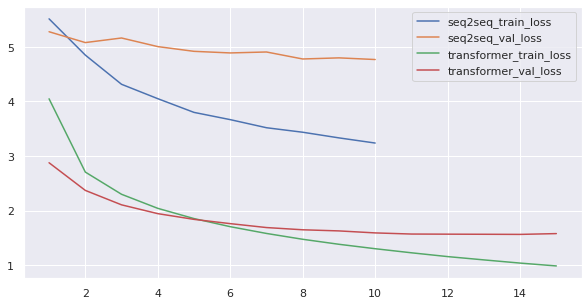

In [104]:
plt.figure(figsize=(10,5))
for model in results.keys():
    for loss in ["train_loss", "val_loss"]:
        y = results[model][loss]
        if type(y[0]) == torch.Tensor:
            y =  [y_i.detach().cpu().numpy() for y_i in y]
        x = range(1, len(y) + 1)
        plt.plot(x, y, label=model+"_"+loss)
    
    
plt.legend()
plt.show()